# Library Imports & Project Setup

In [1]:
import os
import random
import cv2
import copy
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet18_Weights, MobileNet_V3_Large_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

c:\Users\mrina\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Colours:
    HEADER = '\033[95m'     # Miscellaneous
    BLUE = '\033[94m'       # Hyperparameters
    GREEN = '\033[92m'      # Accuracies
    RED = '\033[91m'        # Loss
    ENDC = '\033[0m'        # End Colours
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# Set up GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {Colours.HEADER}{device}{Colours.ENDC}")

Using device: cuda


In [4]:
# Set up Optuna verbosity to see detailed output for every trial
optuna.logging.set_verbosity(optuna.logging.INFO)

In [5]:
# Set directory path for dataset
input_directory = "Enhanced_Rocks_Dataset"

# Dataset Sampling, Splitting, & Loading

In [6]:
# Set target number of images per class
target_num_images = 1500

# Under-sample the dataset
undersampled_images = {'igneous': [], 'metamorphic': [], 'sedimentary': []}

for class_name in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_name)
    image_files = os.listdir(class_path)

    if len(image_files) > target_num_images:
        sampled_images = random.sample(image_files, target_num_images)
    else:
        sampled_images = image_files

    # Store paths for under-sampled images
    undersampled_images[class_name] = [os.path.join(class_path, img) for img in sampled_images]

In [7]:
# Split dataset into training, validation, and test sets

image_data = []

for class_name, images in undersampled_images.items():
    image_data += [(img_path, class_name) for img_path in images]

trainval_imageset, test_imageset = train_test_split(image_data, test_size=0.1, random_state=42, stratify=[label for _, label in image_data])
train_imageset, val_imageset = train_test_split(trainval_imageset, test_size=0.1, random_state=42, stratify=[label for _, label in trainval_imageset])

In [8]:
# Define PyTorch Dataset
class RockDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]

        # Load image using OpenCV
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"Image at path {img_path} could not be loaded.")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label_map = {'igneous': 0, 'metamorphic': 1, 'sedimentary': 2}
        label = torch.tensor(label_map[label], dtype=torch.long)

        return image, label

In [9]:
# Define image transformations (resize, data augmentation, convert to tensor, normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((120, 120)),
    transforms.RandomHorizontalFlip(),  # Data Augmentation - horizontal flip
    transforms.RandomVerticalFlip(),    # Data Augmentation - vertical flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard normalization
])

# Create datasets
train_dataset = RockDataset(train_imageset, transform=transform)
val_dataset = RockDataset(val_imageset, transform=transform)
trainval_dataset = RockDataset(trainval_imageset, transform=transform)
test_dataset = RockDataset(test_imageset, transform=transform)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Custom 11-Layer Convolutional Neural Network

## Model Architecture

In [10]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional & Pooling Layers (Feature Extraction)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # Variable to hold the output size after feature extraction and flattening
        self._output_size = None
        # Fully-Connected Layers (Classification)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),   # Placeholder; Will be updated
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Neuron Dropout for Regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Neuron Dropout for Regularization
            nn.Linear(4096, 3)  # Output 3 classes: Igneous, Metamorphic, Sedimentary
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        
        # Dynamically determine correct input size for classification
        if self._output_size is None:
            self._output_size = x.shape[1]
            self.classifier[0] = nn.Linear(self._output_size, 4096).to(x.device)    # Update first fully-conencted layer with correct input size
        
        x = self.classifier(x)

        return x

## Hyperparameter Tuning

In [11]:
# Instantiate the model and move it to GPU if available
model = CustomCNN().to(device)

# Define the training parameters and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define hyperparameter tuning objective with Optuna and implement early stopping
def objective(trial):
    # Define hyperparameters to tune
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 75)

    # Update the model's dropout rate
    model.classifier[2].p = dropout_rate
    model.classifier[5].p = dropout_rate

    # Update optimizer based on suggestion
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Set early stopping parameters
    early_stopping_patience = 8
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    model.train()
    
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()

        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {Colours.HEADER}{epoch + 1}{Colours.ENDC}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return accuracy

# Run Optuna study
CCNN_study = optuna.create_study(direction="maximize", study_name="Custom CNN Optimization", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
CCNN_study.optimize(objective, n_trials=15)

# Best hyperparameters
print(f"Best hyperparameters: {Colours.BLUE}{CCNN_study.best_params}{Colours.ENDC}")

[I 2024-11-10 20:20:50,992] A new study created in memory with name: Custom CNN Optimization
[I 2024-11-10 20:28:30,553] Trial 0 finished with value: 0.4345679012345679 and parameters: {'optimizer': 'SGD', 'lr': 0.0003197343097899082, 'dropout_rate': 0.375121798355479, 'weight_decay': 0.0008034893567753313, 'epochs': 68}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 59


[I 2024-11-10 20:30:22,793] Trial 1 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.0028415545663795956, 'dropout_rate': 0.24154222327691396, 'weight_decay': 3.0323068621766544e-05, 'epochs': 42}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 16


[I 2024-11-10 20:31:49,409] Trial 2 finished with value: 0.4 and parameters: {'optimizer': 'Adam', 'lr': 0.0006377412966013475, 'dropout_rate': 0.3621006910661245, 'weight_decay': 0.0004258190763848468, 'epochs': 40}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 12


[I 2024-11-10 20:33:05,957] Trial 3 finished with value: 0.4246913580246914 and parameters: {'optimizer': 'SGD', 'lr': 0.00459719423247734, 'dropout_rate': 0.47344248653821797, 'weight_decay': 0.00012340551139754417, 'epochs': 43}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 11


[I 2024-11-10 20:35:03,828] Trial 4 finished with value: 0.4148148148148148 and parameters: {'optimizer': 'SGD', 'lr': 0.0031486826479799274, 'dropout_rate': 0.3290778108466701, 'weight_decay': 0.00017425507450351656, 'epochs': 30}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 16


[I 2024-11-10 20:36:19,276] Trial 5 finished with value: 0.4246913580246914 and parameters: {'optimizer': 'SGD', 'lr': 0.0008641956661033911, 'dropout_rate': 0.2645463629899089, 'weight_decay': 2.0958775382148308e-05, 'epochs': 20}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 10


[I 2024-11-10 20:37:30,815] Trial 6 finished with value: 0.4222222222222222 and parameters: {'optimizer': 'SGD', 'lr': 0.005359014237676539, 'dropout_rate': 0.45509262999139277, 'weight_decay': 0.003892574927494398, 'epochs': 27}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 10


[I 2024-11-10 20:39:16,710] Trial 7 finished with value: 0.4222222222222222 and parameters: {'optimizer': 'Adam', 'lr': 0.0003314165200398677, 'dropout_rate': 0.48278683243988224, 'weight_decay': 0.0003297084886190587, 'epochs': 41}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 15


[I 2024-11-10 20:41:18,570] Trial 8 finished with value: 0.4271604938271605 and parameters: {'optimizer': 'Adam', 'lr': 0.00023701934855376733, 'dropout_rate': 0.3059631252505476, 'weight_decay': 0.0002482191991025184, 'epochs': 42}. Best is trial 0 with value: 0.4345679012345679.


Early stopping at epoch 16


[I 2024-11-10 20:42:26,428] Trial 9 finished with value: 0.43950617283950616 and parameters: {'optimizer': 'SGD', 'lr': 0.00011848179918097788, 'dropout_rate': 0.2769328362356557, 'weight_decay': 9.998029587129815e-05, 'epochs': 60}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 9


[I 2024-11-10 20:43:33,382] Trial 10 finished with value: 0.42962962962962964 and parameters: {'optimizer': 'SGD', 'lr': 0.00012793314554346232, 'dropout_rate': 0.4118599200299318, 'weight_decay': 0.008451112472572454, 'epochs': 71}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 9


[I 2024-11-10 20:44:53,507] Trial 11 finished with value: 0.4222222222222222 and parameters: {'optimizer': 'SGD', 'lr': 0.00010538789443768005, 'dropout_rate': 0.20301363440581824, 'weight_decay': 0.0010815131896105303, 'epochs': 69}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 11


[I 2024-11-10 20:46:56,840] Trial 12 finished with value: 0.41975308641975306 and parameters: {'optimizer': 'SGD', 'lr': 0.0003055732578722273, 'dropout_rate': 0.3782440624193643, 'weight_decay': 6.287009333735752e-05, 'epochs': 59}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 17


[I 2024-11-10 20:48:10,348] Trial 13 finished with value: 0.41728395061728396 and parameters: {'optimizer': 'SGD', 'lr': 0.00019382670176629053, 'dropout_rate': 0.2924308960729835, 'weight_decay': 0.0011013112900913294, 'epochs': 59}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 10


[I 2024-11-10 20:49:16,241] Trial 14 finished with value: 0.4246913580246914 and parameters: {'optimizer': 'SGD', 'lr': 0.0004901579912770373, 'dropout_rate': 0.4094584008669005, 'weight_decay': 1.0574448410814587e-05, 'epochs': 58}. Best is trial 9 with value: 0.43950617283950616.


Early stopping at epoch 9
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.00011848179918097788, 'dropout_rate': 0.2769328362356557, 'weight_decay': 9.998029587129815e-05, 'epochs': 60}


## Model Validation

In [12]:
# Update model parameters with best hyperparameters
model.classifier[2].p = CCNN_study.best_params['dropout_rate']
model.classifier[5].p = CCNN_study.best_params['dropout_rate']

if CCNN_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=CCNN_study.best_params['lr'], weight_decay=CCNN_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=CCNN_study.best_params['lr'], momentum=0.9, weight_decay=CCNN_study.best_params['weight_decay'])

best_epochs = CCNN_study.best_params['epochs']

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Re-train the model with the best hyperparameters
model.train()

for epoch in range(best_epochs):
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()

    val_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = correct / len(val_loader.dataset)
    val_accuracies.append(accuracy)

print(f"Validation Loss: {Colours.RED}{val_loss:.4f}{Colours.ENDC}")
print(f"Validation Accuracy: {Colours.GREEN}{accuracy:.2f}{Colours.ENDC}")

Validation Loss: 1.0716
Validation Accuracy: 0.42


## Validation Visualizations

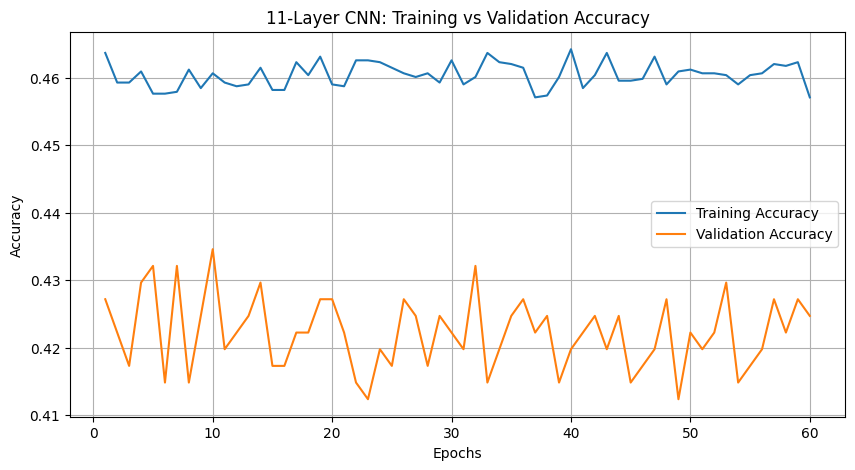

In [13]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('11-Layer CNN: Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

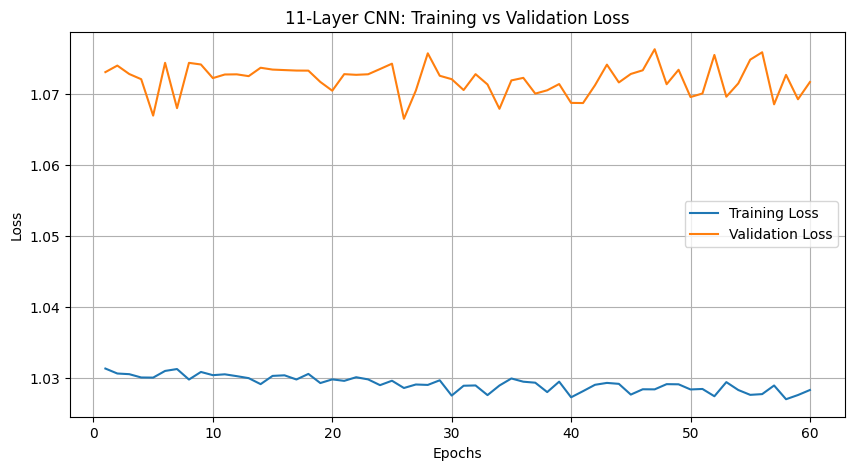

In [14]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('11-Layer CNN: Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

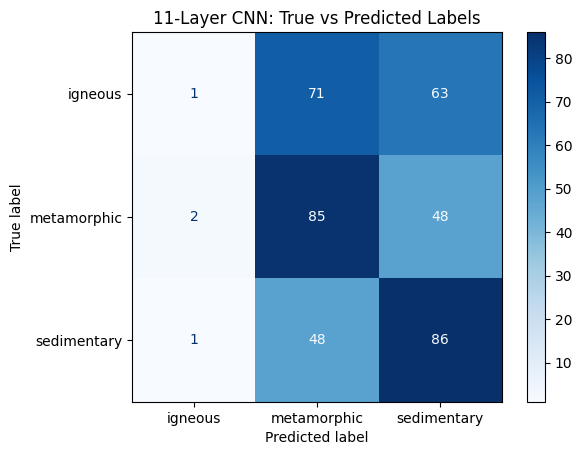

In [15]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['igneous', 'metamorphic', 'sedimentary'])
disp.plot(cmap='Blues')
plt.title("11-Layer CNN: True vs Predicted Labels")
plt.show()

# ResNet-18 Convolutional Neural Network w/ Weights

## Model Definition

In [16]:
# Load ResNet-18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, 3)  # Update the final layer to match the number of classes

model = model.to(device)

## Hyperparameter Tuning

In [17]:
# Define the training parameters and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define hyperparameter tuning objective with Optuna and implement early stopping
def objective(trial):
    # Define hyperparameters to tune
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 75)

    # Update optimizer based on suggestion
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Set early stopping parameters
    early_stopping_patience = 8
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    model.train()

    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()

        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {Colours.HEADER}{epoch + 1}{Colours.ENDC}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return accuracy

# Run Optuna study
ResNet18_study = optuna.create_study(direction="maximize", study_name="ResNet-18 Optimization", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
ResNet18_study.optimize(objective, n_trials=15)

# Best hyperparameters
print(f"Best hyperparameters: {Colours.BLUE}{ResNet18_study.best_params}{Colours.ENDC}")

[I 2024-11-10 20:58:54,138] A new study created in memory with name: ResNet-18 Optimization
[I 2024-11-10 21:00:28,922] Trial 0 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.008048312518680212, 'weight_decay': 0.009186435802608143, 'epochs': 26}. Best is trial 0 with value: 0.3333333333333333.


Early stopping at epoch 10


[I 2024-11-10 21:06:05,803] Trial 1 finished with value: 0.39753086419753086 and parameters: {'optimizer': 'Adam', 'lr': 0.0003064554991948869, 'weight_decay': 0.0069715497613742575, 'epochs': 33}. Best is trial 1 with value: 0.39753086419753086.
[I 2024-11-10 21:09:14,722] Trial 2 finished with value: 0.4148148148148148 and parameters: {'optimizer': 'Adam', 'lr': 0.0007173071783871547, 'weight_decay': 1.017920731410191e-05, 'epochs': 72}. Best is trial 2 with value: 0.4148148148148148.


Early stopping at epoch 19


[I 2024-11-10 21:11:03,131] Trial 3 finished with value: 0.41975308641975306 and parameters: {'optimizer': 'SGD', 'lr': 0.00031671411770553066, 'weight_decay': 1.1506397368456697e-05, 'epochs': 73}. Best is trial 3 with value: 0.41975308641975306.


Early stopping at epoch 11


[I 2024-11-10 21:16:45,114] Trial 4 finished with value: 0.4666666666666667 and parameters: {'optimizer': 'Adam', 'lr': 0.00011822658057923303, 'weight_decay': 0.00065824188222595, 'epochs': 40}. Best is trial 4 with value: 0.4666666666666667.


Early stopping at epoch 35


[I 2024-11-10 21:20:13,903] Trial 5 finished with value: 0.4641975308641975 and parameters: {'optimizer': 'SGD', 'lr': 0.0025875908808632234, 'weight_decay': 1.631018705992466e-05, 'epochs': 50}. Best is trial 4 with value: 0.4666666666666667.


Early stopping at epoch 21


[I 2024-11-10 21:22:39,880] Trial 6 finished with value: 0.3802469135802469 and parameters: {'optimizer': 'Adam', 'lr': 0.0006645191440889423, 'weight_decay': 0.0007779601129306234, 'epochs': 28}. Best is trial 4 with value: 0.4666666666666667.


Early stopping at epoch 14


[I 2024-11-10 21:25:21,935] Trial 7 finished with value: 0.43950617283950616 and parameters: {'optimizer': 'SGD', 'lr': 0.0037647646073075006, 'weight_decay': 0.00014742458374633814, 'epochs': 18}. Best is trial 4 with value: 0.4666666666666667.


Early stopping at epoch 16


[I 2024-11-10 21:29:07,554] Trial 8 finished with value: 0.4691358024691358 and parameters: {'optimizer': 'SGD', 'lr': 0.0028871214356648647, 'weight_decay': 0.0015922054838573509, 'epochs': 28}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 24


[I 2024-11-10 21:32:51,257] Trial 9 finished with value: 0.4345679012345679 and parameters: {'optimizer': 'Adam', 'lr': 0.0018978503482003596, 'weight_decay': 1.503818424238341e-05, 'epochs': 25}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 24


[I 2024-11-10 21:34:33,068] Trial 10 finished with value: 0.42962962962962964 and parameters: {'optimizer': 'SGD', 'lr': 0.007966941195349103, 'weight_decay': 0.0022060254864720236, 'epochs': 11}. Best is trial 8 with value: 0.4691358024691358.
[I 2024-11-10 21:36:35,637] Trial 11 finished with value: 0.42962962962962964 and parameters: {'optimizer': 'SGD', 'lr': 0.00013426214140646592, 'weight_decay': 0.00020745510101869937, 'epochs': 47}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 13


[I 2024-11-10 21:39:58,913] Trial 12 finished with value: 0.4469135802469136 and parameters: {'optimizer': 'SGD', 'lr': 0.0001204790240153392, 'weight_decay': 0.0009084286704400606, 'epochs': 40}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 22


[I 2024-11-10 21:41:53,288] Trial 13 finished with value: 0.4345679012345679 and parameters: {'optimizer': 'Adam', 'lr': 0.001027566519761248, 'weight_decay': 8.204802757634484e-05, 'epochs': 58}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 12


[I 2024-11-10 21:43:22,290] Trial 14 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.004113776895905951, 'weight_decay': 0.0016430039327902674, 'epochs': 37}. Best is trial 8 with value: 0.4691358024691358.


Early stopping at epoch 9
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.0028871214356648647, 'weight_decay': 0.0015922054838573509, 'epochs': 28}


## Model Validation

In [18]:
# Update model parameters with best hyperparameters
if ResNet18_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=ResNet18_study.best_params['lr'], weight_decay=ResNet18_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=ResNet18_study.best_params['lr'], momentum=0.9, weight_decay=ResNet18_study.best_params['weight_decay'])

best_epochs = ResNet18_study.best_params['epochs']

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Re-train the model with the best hyperparameters
model.train()

for epoch in range(best_epochs):
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()

    val_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = correct / len(val_loader.dataset)
    val_accuracies.append(accuracy)

print(f"Validation Loss: {Colours.RED}{val_loss:.4f}{Colours.ENDC}")
print(f"Validation Accuracy: {Colours.GREEN}{accuracy:.2f}{Colours.ENDC}")

Validation Loss: 1.0484
Validation Accuracy: 0.45


## Validation Visualizations

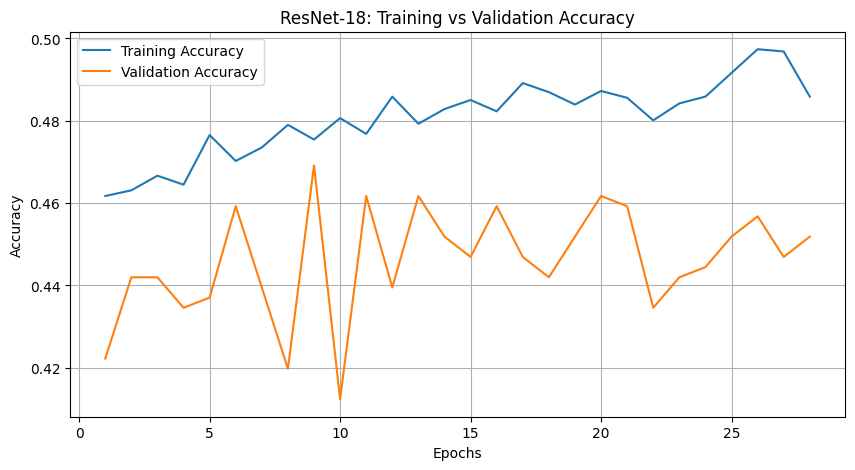

In [19]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet-18: Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

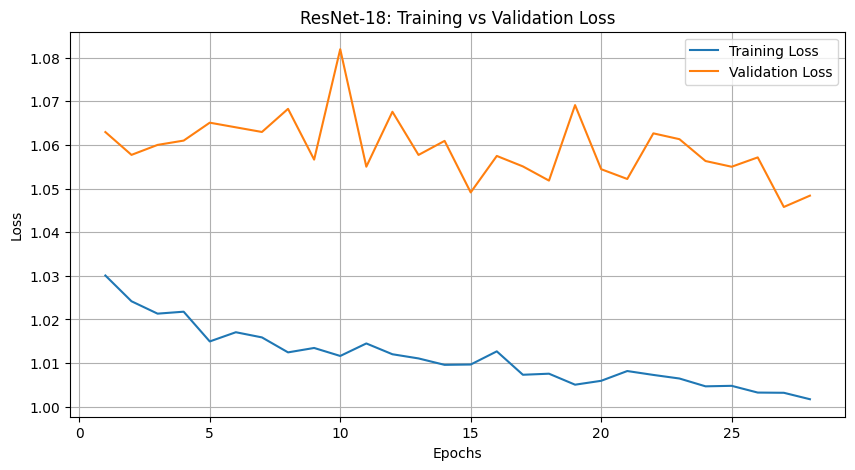

In [20]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet-18: Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

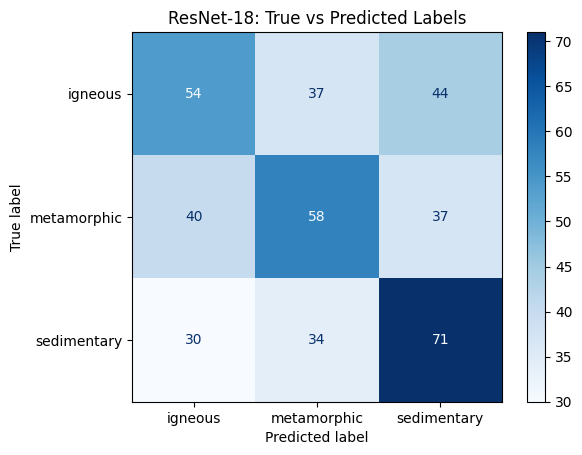

In [21]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['igneous', 'metamorphic', 'sedimentary'])
disp.plot(cmap='Blues')
plt.title("ResNet-18: True vs Predicted Labels")
plt.show()

# MobileNet V3 Large Convolutonal Neural Network w/ Weights

## Model Definition

In [22]:
# Load MobileNet model
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

# Get the input features for the classifier
in_features = model.classifier[0].in_features  # This should be 960 for MobileNetV3 Large

# Redefine the classifier to match the number of input features and output classes
model.classifier = nn.Sequential(
    nn.Linear(in_features, 1280),
    nn.Hardswish(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 3)
)

model = model.to(device)

## Hyperparameter Tuning

In [23]:
# Define the training parameters and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define hyperparameter tuning objective with Optuna and implement early stopping
def objective(trial):
    # Define hyperparameters to tune
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 75)

    # Update optimizer based on suggestion
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Set early stopping parameters
    early_stopping_patience = 8
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    model.train()

    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()

        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {Colours.HEADER}{epoch + 1}{Colours.ENDC}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return accuracy

# Run Optuna study
MobileNetV3L_study = optuna.create_study(direction="maximize", study_name="MobileNet V3 Large Optimization", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
MobileNetV3L_study.optimize(objective, n_trials=15)

# Best hyperparameters
print(f"Best hyperparameters: {Colours.BLUE}{MobileNetV3L_study.best_params}{Colours.ENDC}")

[I 2024-11-10 21:49:00,331] A new study created in memory with name: MobileNet V3 Large Optimization
[I 2024-11-10 21:50:47,033] Trial 0 finished with value: 0.5037037037037037 and parameters: {'optimizer': 'Adam', 'lr': 0.0004917386573029677, 'weight_decay': 2.88757287807582e-05, 'epochs': 71}. Best is trial 0 with value: 0.5037037037037037.


Early stopping at epoch 9


[I 2024-11-10 21:53:36,311] Trial 1 finished with value: 0.47160493827160493 and parameters: {'optimizer': 'Adam', 'lr': 0.00028617954755305196, 'weight_decay': 0.0029572313592671003, 'epochs': 15}. Best is trial 0 with value: 0.5037037037037037.


Early stopping at epoch 13


[I 2024-11-10 21:57:03,333] Trial 2 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.0017811841108240718, 'weight_decay': 0.00047548886702744326, 'epochs': 57}. Best is trial 0 with value: 0.5037037037037037.


Early stopping at epoch 17


[I 2024-11-10 22:00:22,990] Trial 3 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.0003943858194600672, 'weight_decay': 5.926274043236546e-05, 'epochs': 28}. Best is trial 0 with value: 0.5037037037037037.


Early stopping at epoch 17


[I 2024-11-10 22:07:04,007] Trial 4 finished with value: 0.45925925925925926 and parameters: {'optimizer': 'SGD', 'lr': 0.00017405075127684214, 'weight_decay': 2.6339633989473987e-05, 'epochs': 34}. Best is trial 0 with value: 0.5037037037037037.
[I 2024-11-10 22:13:39,544] Trial 5 finished with value: 0.5654320987654321 and parameters: {'optimizer': 'Adam', 'lr': 0.00015317119117575853, 'weight_decay': 0.0011485963323259877, 'epochs': 63}. Best is trial 5 with value: 0.5654320987654321.


Early stopping at epoch 33


[I 2024-11-10 22:17:49,617] Trial 6 finished with value: 0.5753086419753086 and parameters: {'optimizer': 'SGD', 'lr': 0.0041991975519387725, 'weight_decay': 2.468775933903773e-05, 'epochs': 23}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 22


[I 2024-11-10 22:19:48,031] Trial 7 finished with value: 0.5580246913580247 and parameters: {'optimizer': 'SGD', 'lr': 0.00011140263846650693, 'weight_decay': 1.0080216113031613e-05, 'epochs': 71}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 10


[I 2024-11-10 22:21:52,879] Trial 8 finished with value: 0.5234567901234568 and parameters: {'optimizer': 'Adam', 'lr': 0.00018365968065420278, 'weight_decay': 0.005728988767671614, 'epochs': 25}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 10


[I 2024-11-10 22:23:32,213] Trial 9 finished with value: 0.5234567901234568 and parameters: {'optimizer': 'SGD', 'lr': 0.006358764461072006, 'weight_decay': 2.8981756571832973e-05, 'epochs': 11}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 9


[I 2024-11-10 22:25:13,847] Trial 10 finished with value: 0.3333333333333333 and parameters: {'optimizer': 'SGD', 'lr': 0.009716016170371052, 'weight_decay': 0.000147404654990694, 'epochs': 45}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 9


[I 2024-11-10 22:28:21,820] Trial 11 finished with value: 0.49135802469135803 and parameters: {'optimizer': 'SGD', 'lr': 0.002250645320129063, 'weight_decay': 0.000941354480289325, 'epochs': 51}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 16


[I 2024-11-10 22:31:57,299] Trial 12 finished with value: 0.38765432098765434 and parameters: {'optimizer': 'Adam', 'lr': 0.0008796000421743007, 'weight_decay': 0.0012998799954840638, 'epochs': 55}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 17


[I 2024-11-10 22:39:45,734] Trial 13 finished with value: 0.5012345679012346 and parameters: {'optimizer': 'SGD', 'lr': 0.0033665330077724963, 'weight_decay': 0.0003270158061795694, 'epochs': 64}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 41


[I 2024-11-10 22:44:49,970] Trial 14 finished with value: 0.5185185185185185 and parameters: {'optimizer': 'Adam', 'lr': 0.0009167799975040401, 'weight_decay': 0.00012511600266138187, 'epochs': 38}. Best is trial 6 with value: 0.5753086419753086.


Early stopping at epoch 26
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.0041991975519387725, 'weight_decay': 2.468775933903773e-05, 'epochs': 23}


## Model Validation

In [24]:
# Update model parameters with best hyperparameters
if MobileNetV3L_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=MobileNetV3L_study.best_params['lr'], weight_decay=MobileNetV3L_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=MobileNetV3L_study.best_params['lr'], momentum=0.9, weight_decay=MobileNetV3L_study.best_params['weight_decay'])

best_epochs = MobileNetV3L_study.best_params['epochs']

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Re-train the model with the best hyperparameters
model.train()

for epoch in range(best_epochs):
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation set
    model.eval()

    val_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = correct / len(val_loader.dataset)
    val_accuracies.append(accuracy)

print(f"Validation Loss: {Colours.RED}{val_loss:.4f}{Colours.ENDC}")
print(f"Validation Accuracy: {Colours.GREEN}{accuracy:.2f}{Colours.ENDC}")

Validation Loss: 0.9991
Validation Accuracy: 0.52


## Validation Visualizations

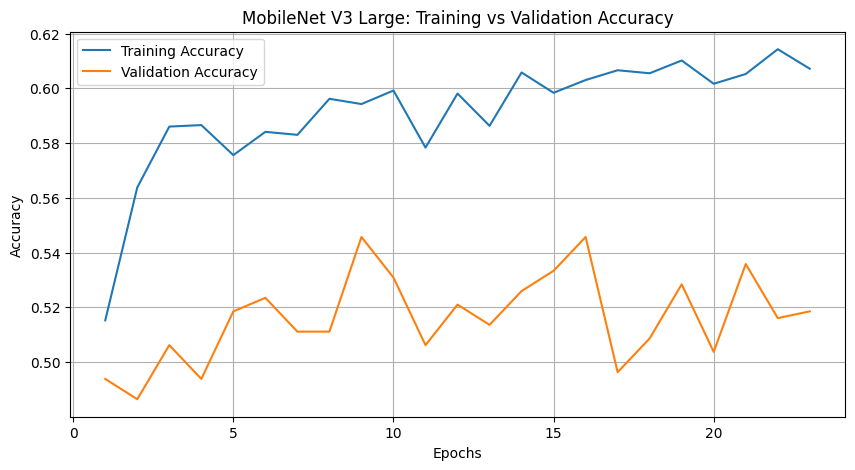

In [25]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V3 Large: Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

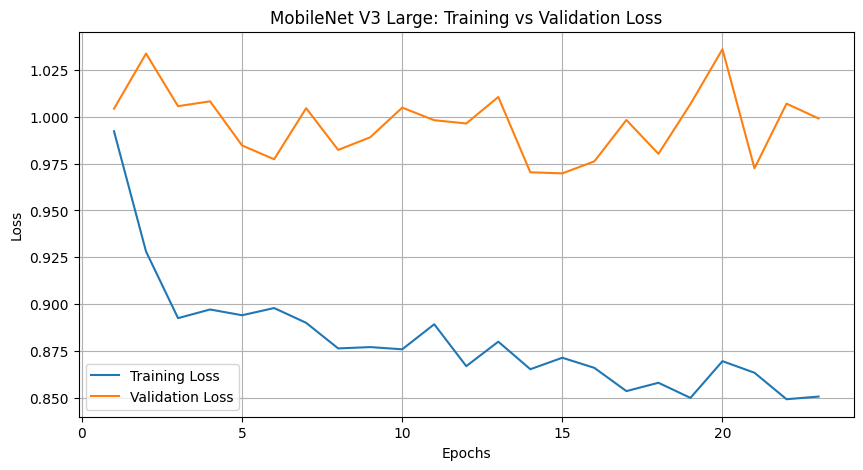

In [26]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet V3 Large: Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

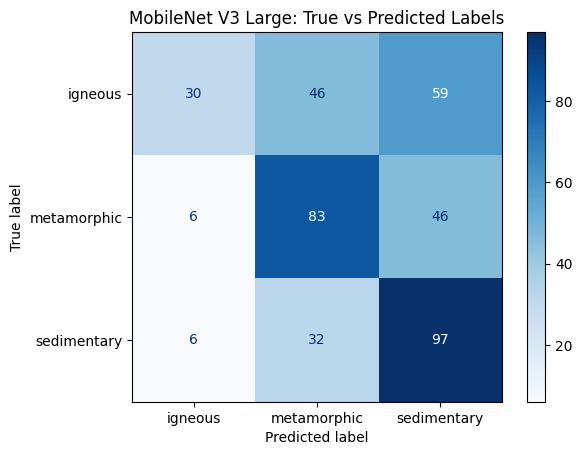

In [27]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['igneous', 'metamorphic', 'sedimentary'])
disp.plot(cmap='Blues')
plt.title("MobileNet V3 Large: True vs Predicted Labels")
plt.show()

# Final Training

In [28]:
# Instantiate the Custom 11-Layer CNN model and move it to GPU if available
CCNN_model = CustomCNN().to(device)

In [29]:
# Instantiate the ResNet-18 model, update the classification layer, and move it to GPU if available
ResNet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet18_model.fc = nn.Linear(ResNet18_model.fc.in_features, 3)  # Update the final layer to match the number of classes

ResNet18_model = ResNet18_model.to(device)

In [30]:
# Instantiate the MobileNet V3 Large model, update the classification layer, and move it to GPU if available
MobileNetV3L_model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

in_features = MobileNetV3L_model.classifier[-1].in_features
MobileNetV3L_model.classifier[-1] = nn.Linear(in_features, 3)  # Update the final layer to match the number of classes

MobileNetV3L_model = MobileNetV3L_model.to(device)

In [31]:
# Final Training for Custom 11-Layer CNN model #

# Set model parameters with best hyperparameters
CCNN_model.classifier[2].p = CCNN_study.best_params['dropout_rate']
CCNN_model.classifier[5].p = CCNN_study.best_params['dropout_rate']

if CCNN_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(CCNN_model.parameters(), lr=CCNN_study.best_params['lr'], weight_decay=CCNN_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(CCNN_model.parameters(), lr=CCNN_study.best_params['lr'], momentum=0.9, weight_decay=CCNN_study.best_params['weight_decay'])

best_epochs = CCNN_study.best_params['epochs']

# Train the model for the final time
CCNN_model.train()

for epoch in range(best_epochs):
    for images, labels in trainval_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [32]:
# Final Training for ResNet-18 model w/ Pre-Trained Weights #

# Set model parameters with best hyperparameters
if ResNet18_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=ResNet18_study.best_params['lr'], weight_decay=ResNet18_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=ResNet18_study.best_params['lr'], momentum=0.9, weight_decay=ResNet18_study.best_params['weight_decay'])

best_epochs = ResNet18_study.best_params['epochs']

# Train the model for the final time
ResNet18_model.train()

for epoch in range(best_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [33]:
# Final Training for MobileNet V3 Large model w/ Pre-Trained Weights #

# Set model parameters with best hyperparameters
if MobileNetV3L_study.best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=MobileNetV3L_study.best_params['lr'], weight_decay=MobileNetV3L_study.best_params['weight_decay'])
else:
    optimizer = optim.SGD(model.parameters(), lr=MobileNetV3L_study.best_params['lr'], momentum=0.9, weight_decay=MobileNetV3L_study.best_params['weight_decay'])

best_epochs = MobileNetV3L_study.best_params['epochs']

# Train the model for the final time
MobileNetV3L_model.train()

for epoch in range(best_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Model Testing & Comparative Evaluation

In [34]:
# Evaluate the Custom 11-Layer CNN model on the test set
CCNN_model.eval()

CCNN_test_loss = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        CCNN_test_loss += criterion(outputs, labels).item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

CCNN_test_loss /= len(test_loader)
CCNN_test_accuracy = correct / len(test_loader.dataset)

In [35]:
# Evaluate the ResNet-18 model w/ Pre-Trained Weights on the test set
ResNet18_model.eval()

ResNet18_test_loss = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        ResNet18_test_loss += criterion(outputs, labels).item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

ResNet18_test_loss /= len(test_loader)
ResNet18_test_accuracy = correct / len(test_loader.dataset)

In [36]:
# Evaluate the MobileNet V3 Large model w/ Pre-Trained Weights on the test set
MobileNetV3L_model.eval()

MobileNetV3L_test_loss = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        MobileNetV3L_test_loss += criterion(outputs, labels).item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

MobileNetV3L_test_loss /= len(test_loader)
MobileNetV3L_test_accuracy = correct / len(test_loader.dataset)

In [37]:
print(f"Custom 11-Layer CNN Test Loss: {Colours.RED}{CCNN_test_loss:.4f}{Colours.ENDC}")
print(f"Custom 11-Layer CNN Test Accuracy: {Colours.GREEN}{CCNN_test_accuracy:.2f}{Colours.ENDC}")

print(f"ResNet-18 Test Loss: {Colours.RED}{ResNet18_test_loss:.4f}{Colours.ENDC}")
print(f"ResNet-18 Test Accuracy: {Colours.GREEN}{ResNet18_test_accuracy:.2f}{Colours.ENDC}")

print(f"MobileNet V3 Large Test Loss: {Colours.RED}{MobileNetV3L_test_loss:.4f}{Colours.ENDC}")
print(f"MobileNet V3 Large Test Accuracy: {Colours.GREEN}{MobileNetV3L_test_accuracy:.2f}{Colours.ENDC}")

Custom 11-Layer CNN Test Loss: 1.1852
Custom 11-Layer CNN Test Accuracy: 0.52
ResNet-18 Test Loss: 1.2509
ResNet-18 Test Accuracy: 0.49
MobileNet V3 Large Test Loss: 1.2348
MobileNet V3 Large Test Accuracy: 0.49
